# Import libraries and set seed for reproducibility

In [1]:
! pip install july

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
# if os.sep == '/':
#     from google.colab import drive
#     drive.mount('/gdrive')
#     %cd /gdrive/MyDrive/Colab Notebooks

import tensorflow as tf
from keras.models import load_model
import numpy as np
from datetime import datetime
import glob
import random
import pandas as pd
import random
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

# Random seed for reproducibility
seed = 14

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

from create_dataframes import create_dataframe, create_dataframe_region

from util import from_region_to_index, inspect_dataframe, inspect_multivariate, inspect_multivariate_prediction, test_on_samples
from util import inspect_univariate, inspect_univariate_prediction, build_sequences, from_date_to_index, from_date_to_sample

# Parameters to be set by the user

**The following parameters need to be modified by the user:**
1. `region`: region to choose
    - `region = 'Lombardia'`
    - `region= 'Lazio'`
    - `region = 'Sicilia'`
2. `feature_name`: feature to predict.
    - `feature_name = 'new_daily_infections'`
    - `feature_name = 'deceased'`
    - `feature_name = 'hospitalized'`
    - `feature_name = 'recovered'`
3. `option`: modify this parameter to integrate/compute the first difference of the selected feature (`feature_name`)
    - `option = 'first_difference'`: work with the first difference of the feature (useful for stationarity)
    - `option = 'integrate'`: work with the cumulative values of the feature (if `feature_name` is already cumulative, then an error is raised)
    - `option = None`: work with thedataset as it is
4. `fitting`: 
    - `fitting = True`: train from scratch
    - `fitting = False`: load the models used in the submission 
5. `prediction_type`:
    - `prediction_type = 'oneshot'`: predict all 7 days at once
    - `prediction_type = 'autoregressive'`: use the window past days to predict only one, then include this prediction in the training
set, roll the training window and predict the second day. Repeat this "rolling prediction" procedure until
all 7 days have been predicted.

Our model works with a one-to-one strategy and one shot prediction type, with specific choices for each region:


Lombardia:

| `feature_name`       | `option`      |
| -----------        | ----------- |
| new_daily_infections | None        |
| deceased           | None        |
| hospitalized       | None        |
| recovered          | None        |


Lazio:

| `feature name`       | `option`      |
| -----------        | ----------- |
| new_daily_infections | None        |
| deceased           | "first_difference"        |
| hospitalized       | None        |
| recovered          | "first_difference"        |

Sicilia:

| `feature name`       | `option`      |
| -----------        | ----------- |
|new_daily_infections| None        |
| deceased           | "first_difference"        |
| hospitalized       | None        |
| recovered          | "first_difference"        |

In [3]:
# region
region = 'Lazio'

# feature
option = None
feature_name = "hospitalized" # name of the feature to predict

# fitting
fitting = False

# prediction type
prediction_type = 'oneshot'

# Load and inspect data

In [4]:
print("The selected index is:", from_region_to_index(region))
d1, d2 = create_dataframe_region(from_region_to_index(region))
d = d2

The selected index is: 6
Starting Scraping
dpc-covid19-ita-regioni-20220611.csv | 1 out of 1
Scraping Ended


100%|██████████| 838/838 [00:25<00:00, 33.31it/s]


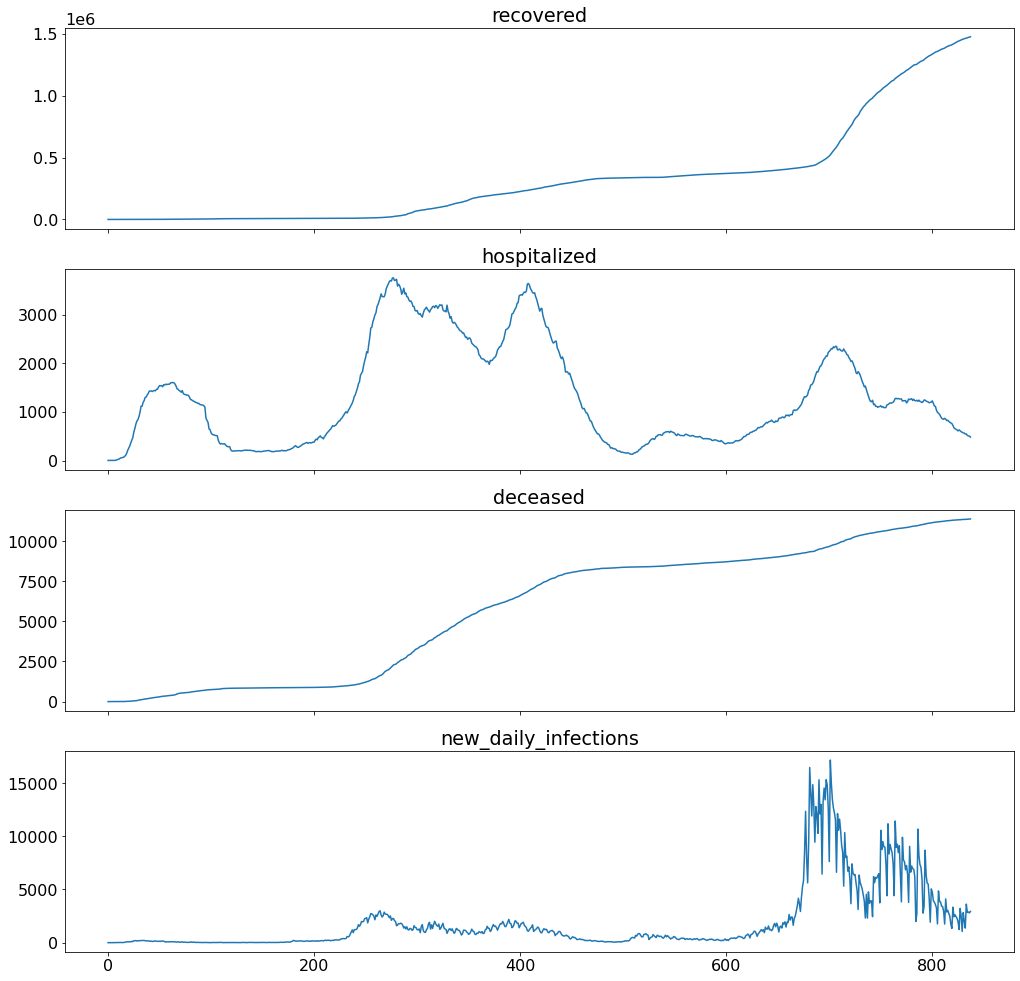

In [5]:
inspect_dataframe(d)

Save the names of the dates for future purposes

In [6]:
cwd = os.getcwd()
days = []
regional_data_covid_path = os.path.join(cwd, "regional_data_covid")
for path in glob.glob(regional_data_covid_path):
    for i, subpath in enumerate(glob.glob(path + os.sep + "*")):
        s = subpath.split("-")[-1]
        s = s.split(".")[0]
        days.append(s)

# Hyperparameters

The following hyperparameters are set:
* `window`: number of days of a single sample
* `stride`: number of days in between two adjacent samples
* `reg_telescope`: number of days to predict
* `telescope`: prediction horizont, default is 7 (one week)
* `batch_size`: batch size for ANN
* `epochs`: epochs for ANN
* `last_prediction_size`: length of last week 
* `target_labels`: columns to predict
* `start_index`: used to remove the first (poorly reported) data

In [7]:
epochs = 1
reg_telescope = 7

if prediction_type == "oneshot":
    telescope = 7
    window  = 21
    stride = 7
    batch_size = 1 
if prediction_type == "autoregressive":
    telescope = 1
    window  = 21
    stride = 7 
    batch_size = 1
    
if prediction_type == "oneshot":
    last_prediction_size = window + telescope
if prediction_type == "autoregressive":
    last_prediction_size = window + reg_telescope    

start_index = stride * 3
print("window:", window)
print("stride:", stride)
print("telescope:", telescope)
print("batch_size:", batch_size)

if prediction_type == "autoregressive":
    print("reg_telescope:", reg_telescope)

window: 21
stride: 7
telescope: 7
batch_size: 1


# Data preprocessing

In [8]:
model_folder = region + "_models" + os.sep # model_folder = name of the folder which contains/will contain the models
target_labels = [feature_name]
cumulative_features_names = ['recovered', 'deceased']
daily_features = []
cumulative_features = []

assert not(option == "integral" and feature_name in cumulative_features_names), "Cannot integrate cumulative features."

if option == "integral" and feature_name not in cumulative_features_names:
  cumulative_features.append(feature_name)
  cum = np.zeros((d.shape[0], len(target_labels)))
  cum[0,0] = d.iloc[0].values
  for i in range(1, d.shape[0], 1):
      cum[i, 0] = d.iloc[i].values + cum[i-1, 0]
  d = pd.DataFrame(cum, columns = [feature_name])

if option == "first_difference":
  daily_features.append(feature_name)
  daily = np.zeros((d.shape[0], len(target_labels)))
  first = d[feature_name][0] # save the first value for later
  daily = np.diff(d[feature_name])
  d = pd.DataFrame(daily, columns = [feature_name])


d = d[feature_name]
d = pd.DataFrame(d)
target_labels = d.columns

Check changes

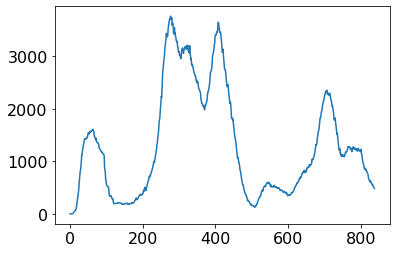

In [9]:
plt.plot(d.values)

# Train - Test split and scaling

In [10]:
X_train_raw = d.iloc[start_index:]
X_last_prediction_raw = d.iloc[-last_prediction_size:]
print(X_train_raw.shape, X_last_prediction_raw.shape)

# Normalize both features and labels
X_min = d.min()
X_max = d.max()
lb = pd.Series(X_min.values, index = X_train_raw.columns, copy = False)
ub = pd.Series(X_max.values,
                index = X_train_raw.columns, copy = False)
X_train_raw = (X_train_raw-lb)/(ub-lb)
X_last_prediction_raw = (X_last_prediction_raw-lb)/(ub-lb)

print("lower bounds:", lb.values)
print("upper bounds:", ub.values)

(817, 1) (28, 1)
lower bounds: [0.]
upper bounds: [3762.]


Constuct training sequences

In [11]:
X_train_old, y_train_old, training_dates = build_sequences(X_train_raw, target_labels, days, window, stride, telescope)

X_last_week = np.zeros((1,window, X_train_old.shape[2]))
y_last_week = np.zeros((1,telescope, X_train_old.shape[2]))
y_last_week_reg = np.zeros((1,reg_telescope, X_train_old.shape[2]))
X_last_week[0] = X_last_prediction_raw.values[:window, :]
y_last_week[0] = X_last_prediction_raw.values[window, :]
y_last_week_reg[0] = X_last_prediction_raw.values[window:, :]

Create test dataset

In [12]:
test_size = int(0.1*X_train_old.shape[0])
exclude = np.random.choice(X_train_old.shape[0],test_size,  replace=False)
mask = np.ones(X_train_old.shape[0], bool)
mask[exclude] = False
X_train = X_train_old[mask == True]
X_test = X_train_old[mask == False]
y_train = y_train_old[mask == True]
y_test = y_train_old[mask == False]
print("number of samples in training:", X_train.shape[0])
print("size of each sample:", X_train.shape[1:])
test_dates = []
for i, b in enumerate(mask):
    if b == False:
        test_dates.append(training_dates[i])

number of samples in training: 102
size of each sample: (21, 1)


Create the training set for each window considered

In [13]:
X_train21 = X_train

X_train14 = X_train[:,-14:,:]

X_train7 = X_train[:,-7:,:]

# Input and Output shapes and inspection of a single batch/sample

In [14]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
print("input shape:",input_shape)
print("output shape:",output_shape)

input shape: (21, 1)
output shape: (7, 1)


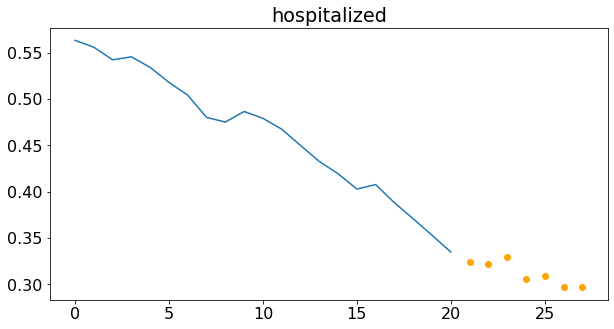

In [15]:
inspect_univariate(X_train, y_train, target_labels, telescope, plot_type = "points")

# Model definition, `model.compile`, `model.summary`

In [16]:
def build_LSTM_model_oneshot(input_shape, output_shape):
    
    input_layer = tfkl.Input(shape=input_shape, name='Input')    
    
    lstm = tfkl.Bidirectional(tfkl.LSTM(128, return_sequences=True))(input_layer)
    lstm = tfkl.Dropout(.1)(lstm)
    output_layer = tfkl.LocallyConnected1D(kernel_size = 1, filters = 1, strides = 1)(lstm)
    output_layer = tfkl.Reshape((input_shape[0],))(output_layer)
    output_layer = tfkl.Dense(7, activation='relu')(output_layer)
    output_layer = tfkl.Reshape((7,1))(output_layer)
    
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')
    # learning_rate = 0.01
    model.compile(loss=tfk.losses.MeanSquaredError(), optimizer=tfk.optimizers.Adam(), metrics=['mae'])

    return model

In [17]:
def build_LSTM_model_autoregressive(input_shape, output_shape):
    
    input_layer = tfkl.Input(shape=input_shape, name='Input')    
    
    lstm = tfkl.Bidirectional(tfkl.LSTM(128, return_sequences=True))(input_layer)
    lstm = tfkl.Dropout(.1)(lstm)
    output_layer = tfkl.LocallyConnected1D(kernel_size = 1, filters = 1, strides = 1)(lstm)
    output_layer = tfkl.Reshape((input_shape[0],))(output_layer)
    output_layer = tfkl.Dense(1, activation='relu')(output_layer)
    output_layer = tfkl.Reshape((1,1))(output_layer)
    
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')
    # learning_rate = 0.01
    model.compile(loss=tfk.losses.MeanSquaredError(), optimizer=tfk.optimizers.Adam(), metrics=['mae'])

    return model

In [18]:
window_average = 21

if prediction_type == 'oneshot':
  model_21 = build_LSTM_model_oneshot(X_train21.shape[1:], output_shape)
  model_14 = build_LSTM_model_oneshot(X_train14.shape[1:], output_shape)
  model_7 = build_LSTM_model_oneshot(X_train7.shape[1:], output_shape)

if prediction_type == 'autoregressive':
  model_21 = build_LSTM_model_autoregressive(X_train21.shape[1:], output_shape)
  model_14 = build_LSTM_model_autoregressive(X_train14.shape[1:], output_shape)
  model_7 = build_LSTM_model_autoregressive(X_train7.shape[1:], output_shape)

# Summary:
model_21.summary()
model_14.summary()
model_7.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 21, 1)]           0         
                                                                 
 bidirectional (Bidirectiona  (None, 21, 256)          133120    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 21, 256)           0         
                                                                 
 locally_connected1d (Locall  (None, 21, 1)            5397      
 yConnected1D)                                                   
                                                                 
 reshape (Reshape)           (None, 21)                0         
                                                                 
 dense (Dense)               (None, 7)                 154   

# `model.fit`

Train the model with window = 21

In [19]:
if fitting:
    history = model_21.fit(
        x = X_train21,
        y = y_train,
        batch_size = batch_size,
        epochs = epochs,
        validation_split=.1,
        callbacks = [
            tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=300, restore_best_weights=True),
            tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.5, min_lr=1e-5)
        ]
    ).history

Train the model with window = 14

In [20]:
if fitting:
    history_14 = model_14.fit(
        x = X_train14,
        y = y_train,
        batch_size = batch_size,
        epochs = epochs,
        validation_split=.1,
        callbacks = [
            tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=300, restore_best_weights=True),
            tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.5, min_lr=1e-5)
        ]
    ).history

Train the model with window = 7

In [21]:
if fitting:
    history_7 = model_7.fit(
        x = X_train7,
        y = y_train,
        batch_size = batch_size,
        epochs = epochs,
        validation_split=.1,
        callbacks = [
            tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=300, restore_best_weights=True),
            tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.5, min_lr=1e-5)
        ]
    ).history

# Plot result of training, using the model with window = 21

In [22]:
if fitting:
    best_epoch = np.argmin(history['val_loss'])
    plt.figure(figsize=(17,4))
    plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
    plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
    plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
    plt.title('Mean Squared Error (Loss)')
    plt.legend()
    plt.grid(alpha=.3)
    plt.show()

    plt.figure(figsize=(17,4))
    plt.plot(history['mae'], label='Training accuracy', alpha=.8, color='#ff7f0e')
    plt.plot(history['val_mae'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
    plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
    plt.title('Mean Absolute Error')
    plt.legend()
    plt.grid(alpha=.3)
    plt.show()

# `model.save` or `model.load`

In [23]:
parent_dir = os.getcwd()
model_folder_path = os.path.join(parent_dir, model_folder) 
if os.path.isdir(model_folder_path) == False:
    os.makedirs(model_folder_path) 
now = datetime.now()

model_name_template = str(now.strftime("%d")) + str(now.strftime("%m")) + str(now.strftime("%Y")) + "_" + str(now.strftime("%H%M%S"))

model_name_21 = feature_name + "_21_" + model_name_template
model_name_14 = feature_name + "_14_" + model_name_template
model_name_7 = feature_name + "_7_" + model_name_template

if fitting:
    model_21.save(model_folder_path + model_name_21)
    model_14.save(model_folder_path + model_name_14)
    model_7.save(model_folder_path + model_name_7)
else:
    model_21 = tfk.models.load_model(model_folder_path + feature_name + "_21")
    model_14 = tfk.models.load_model(model_folder_path + feature_name + "_14")
    model_7 = tfk.models.load_model(model_folder_path + feature_name + "_7")

# Prediction on last available week, using the model with window = 21

This check is performed because it is reasonable to assume that the performance of the model on the week which has just passed might be similar to the performance of the model in the following 7 days. To do so, we use the model with window = 21, since it is the one which often achieves the best results.

In [24]:
predictions = model_21.predict(X_last_week[:,-window_average:,:])
print(predictions.shape)

mean_squared_error = tfk.metrics.mse(y_last_week.flatten(),predictions.flatten())
mean_absolute_error = tfk.metrics.mae(y_last_week.flatten(),predictions.flatten())
print(mean_squared_error, mean_absolute_error)

(1, 7, 1)
tf.Tensor(0.00018015146, shape=(), dtype=float32) tf.Tensor(0.011228719, shape=(), dtype=float32)


Plot it

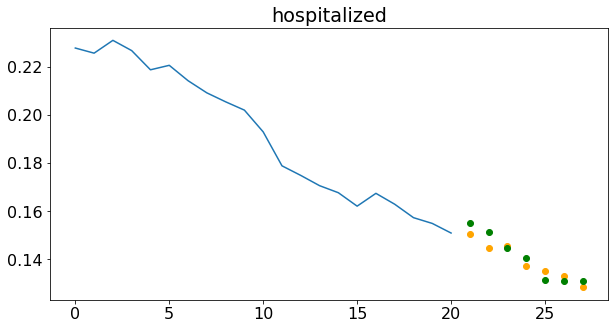

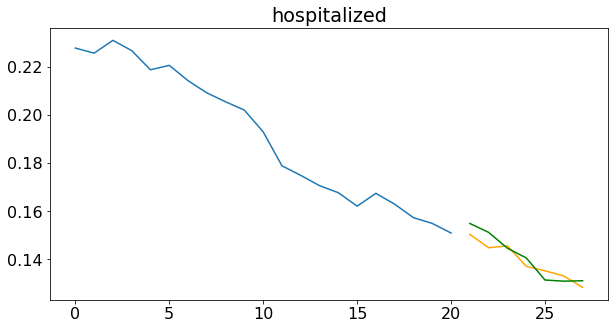

In [25]:
if(prediction_type == 'oneshot'):
  inspect_univariate_prediction(X_last_week, y_last_week_reg, predictions, target_labels, telescope, plot_type = "points")
  inspect_univariate_prediction(X_last_week, y_last_week_reg, predictions, target_labels, telescope, plot_type = "line")

In [26]:
if prediction_type == "autoregressive":
    X_temp = X_last_week
    y_true = y_last_week_reg

    # Autoregressive Forecasting
    reg_predictions = np.array([])
    for reg in range(0,reg_telescope,telescope):
        t = model_21.predict(X_temp)
        pred_temp = np.zeros((t.shape[0],t.shape[1], 1))
        pred_temp[:,:,0] = t
        if(len(reg_predictions)==0):
            reg_predictions = pred_temp
        else:
            reg_predictions = np.concatenate((reg_predictions,pred_temp),axis=1)
        X_temp = np.concatenate((X_temp[:,telescope:,:],pred_temp), axis=1)

    mean_squared_error = tfk.metrics.mse(y_true.flatten(),reg_predictions.flatten())
    mean_absolute_error = tfk.metrics.mae(y_true.flatten(),reg_predictions.flatten())
    print(mean_squared_error, mean_absolute_error)

    inspect_univariate_prediction(X_last_week, y_true, reg_predictions, target_labels, reg_telescope, plot_type = "points")
    inspect_univariate_prediction(X_last_week, y_true, reg_predictions, target_labels, reg_telescope, plot_type = "line")

# Prediction on some new samples, using the model with window = 21

We test the model not only on the test set, but also on some specific dates.

In [27]:
dates_chosen = ["20201231", "20211231", "20200801", "20210801", "20200401", "20210401", "20200909", "20201209",
               "20200415", "20211006", "20210623"]
dates_chosen = []
for test_day in test_dates:
    dates_chosen.append(test_day)
    
model_info = {'window': window_average, 'telescope': telescope, 'reg_telescope': reg_telescope, 'n_features': 1, 'complete_dataset': X_train_raw}
(X_test_samples, y_test_samples, predictions, errors) = test_on_samples(model_21, dates_chosen, model_info, prediction_type = prediction_type)
print("L2 ERRORS:",errors.reshape(1,-1))

Processing date 20200504
Processing date 20200511
Processing date 20200804
Processing date 20201107
Processing date 20210303
Processing date 20201017
Processing date 20211211
Processing date 20201212
Processing date 20211127
Processing date 20220224
Processing date 20211228
L2 ERRORS: [[0.03573488]]


In [28]:
print(X_test_samples.shape, y_test_samples.shape, predictions.shape, errors.shape)

(11, 21, 1) (11, 7, 1) (11, 7, 1) (1, 1)


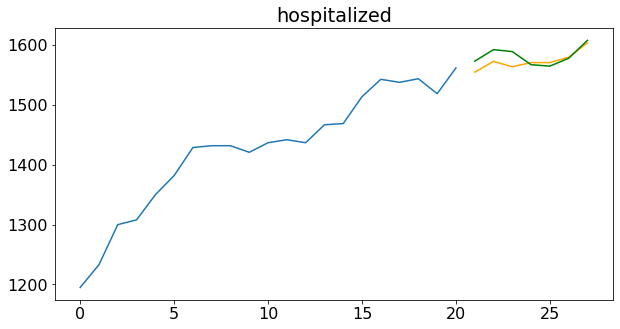

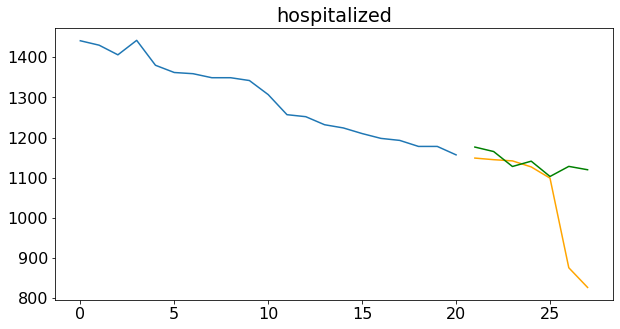

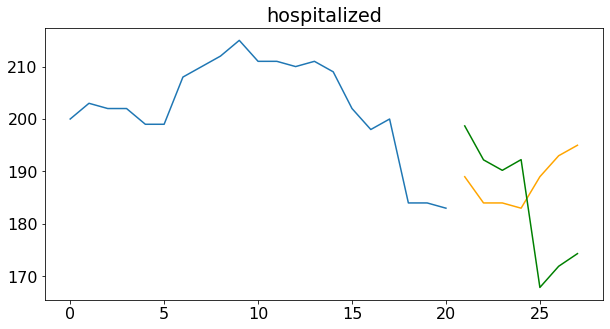

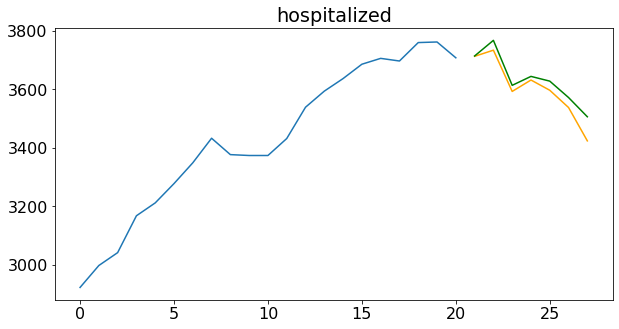

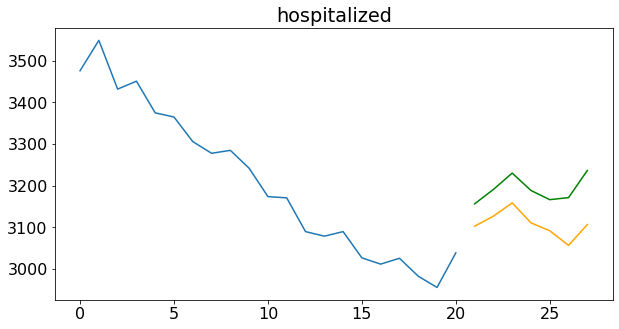

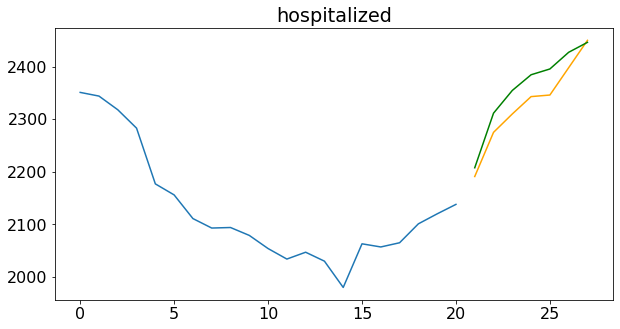

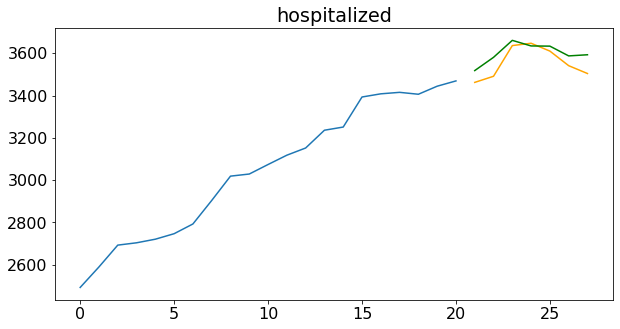

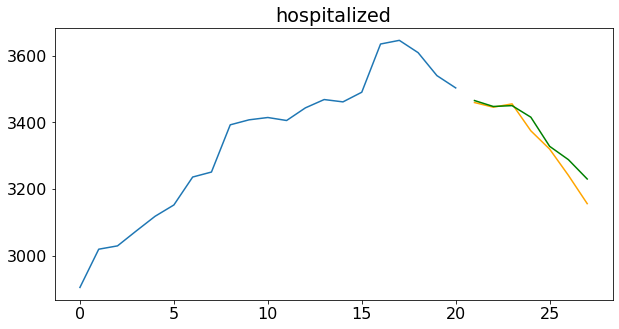

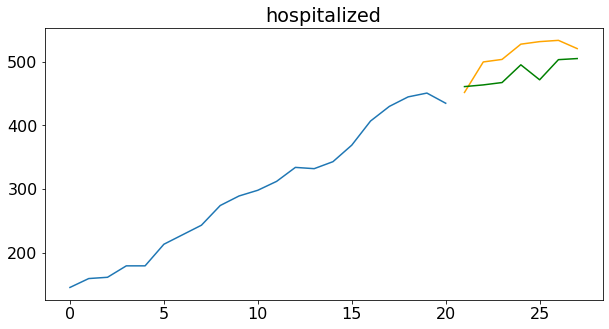

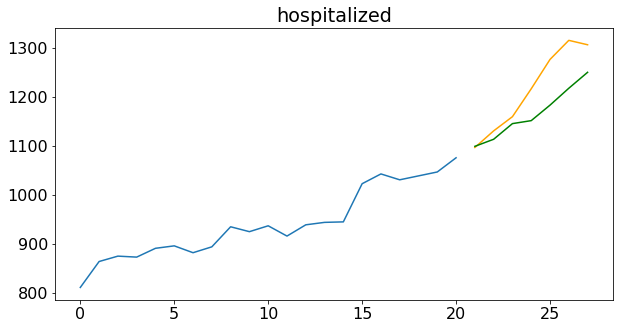

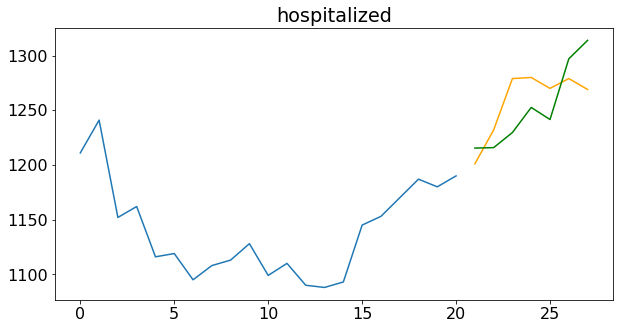

In [29]:
for i in range(len(dates_chosen)):
    X = np.zeros((1, X_test_samples.shape[1], X_test_samples.shape[2]))
    y = np.zeros((1, y_test_samples.shape[1], y_test_samples.shape[2]))
    p = np.zeros((1, predictions.shape[1], predictions.shape[2]))
    X[0] = X_test_samples[i]
    y[0] = y_test_samples[i]
    p[0] = predictions[i]
    inspect_univariate_prediction(X * (ub.values - lb.values) + lb.values, y * (ub.values - lb.values) + lb.values, p * (ub.values - lb.values) + lb.values, target_labels, reg_telescope)

test on the test samples:

window = 21
Processing date 20200504
Processing date 20200511
Processing date 20200804
Processing date 20201107
Processing date 20210303
Processing date 20201017
Processing date 20211211
Processing date 20201212
Processing date 20211127
Processing date 20220224
Processing date 20211228
window = 7
Processing date 20200504
Processing date 20200511
Processing date 20200804
Processing date 20201107
Processing date 20210303
Processing date 20201017
Processing date 20211211
Processing date 20201212
Processing date 20211127
Processing date 20220224
Processing date 20211228
window = 7
Processing date 20200504
Processing date 20200511
Processing date 20200804
Processing date 20201107
Processing date 20210303
Processing date 20201017
Processing date 20211211
Processing date 20201212
Processing date 20211127
Processing date 20220224
Processing date 20211228


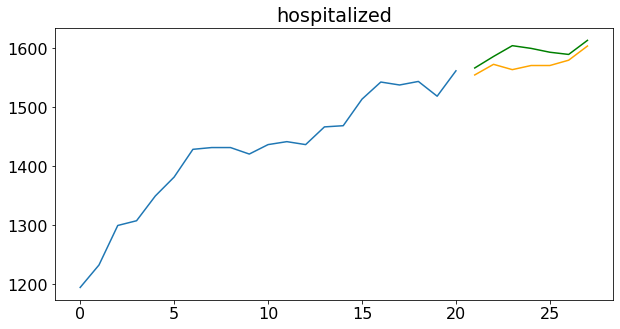

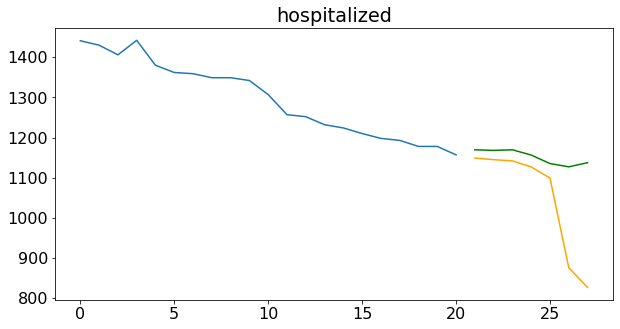

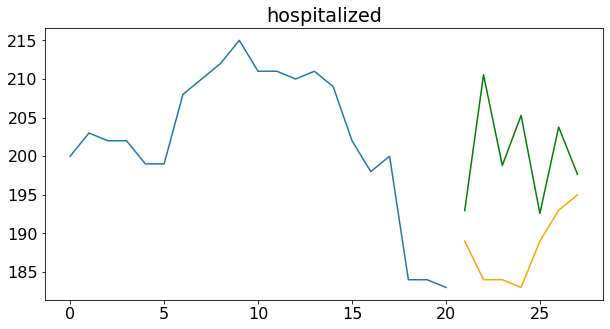

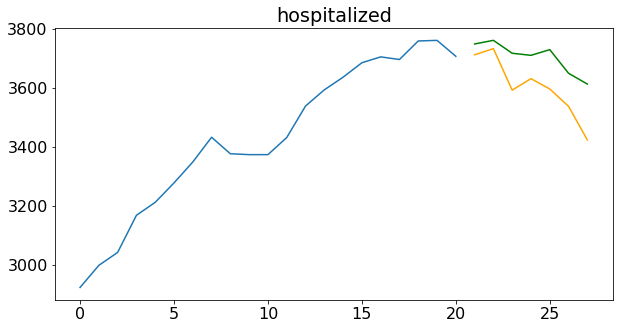

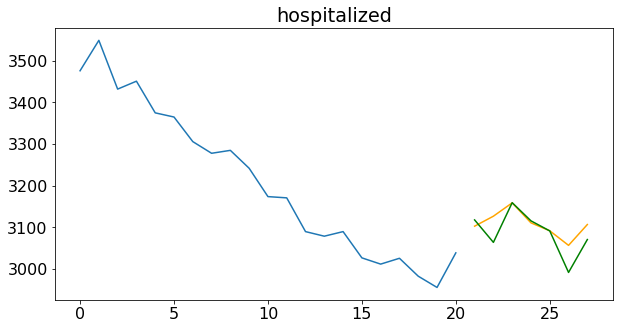

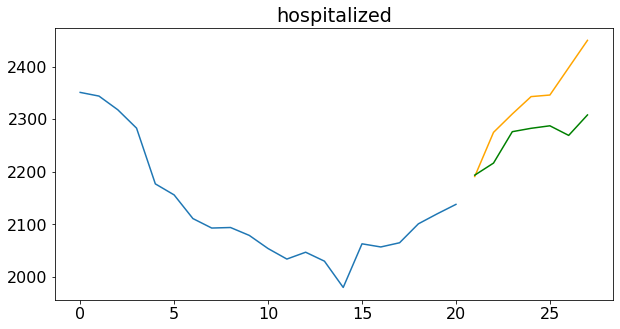

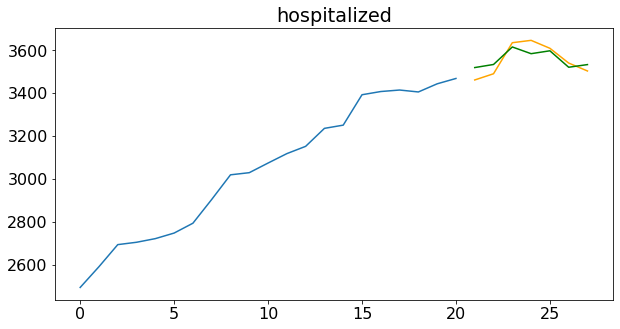

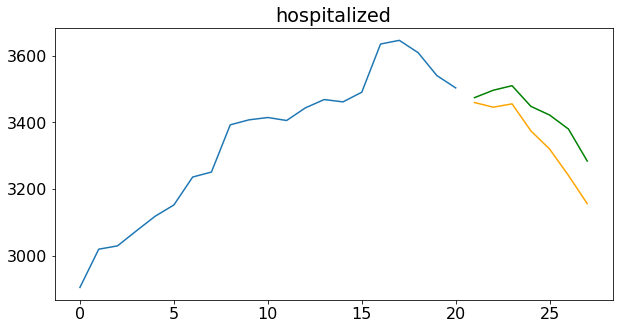

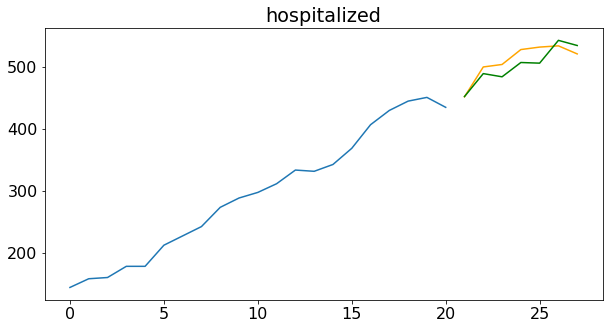

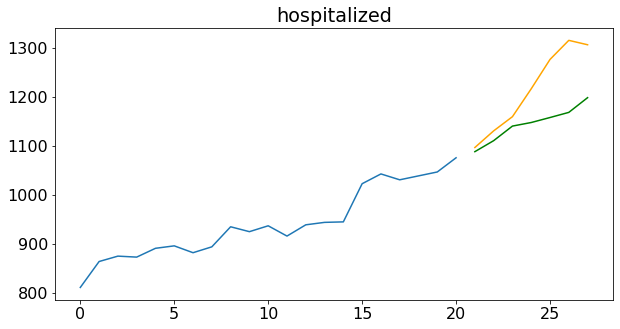

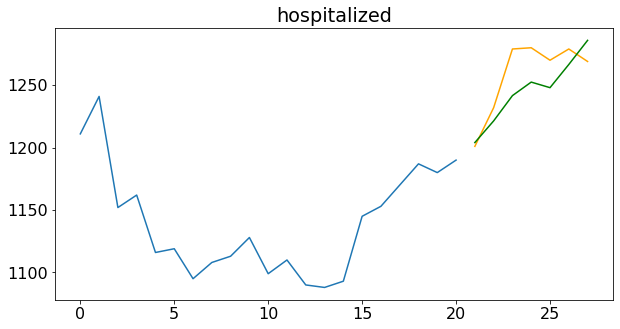

In [30]:
print("window = 21")
model_info_21 = {'window': 21, 'telescope': telescope, 'reg_telescope': reg_telescope, 'n_features': 1, 'complete_dataset': X_train_raw}
(X_test_samples_21, y_test_samples_21, predictions_21, errors_21) = test_on_samples(model_21, dates_chosen, model_info_21, prediction_type = prediction_type)

print("window = 7")
model_info_14 = {'window': 14, 'telescope': telescope, 'reg_telescope': reg_telescope, 'n_features': 1, 'complete_dataset': X_train_raw}
(X_test_samples_14, y_test_samples_14, predictions_14, errors_14) = test_on_samples(model_14, dates_chosen, model_info_14, prediction_type = prediction_type)

print("window = 7")
model_info_7 = {'window': 7, 'telescope': telescope, 'reg_telescope': reg_telescope, 'n_features': 1, 'complete_dataset': X_train_raw}
(X_test_samples_7, y_test_samples_7, predictions_7, errors_7) = test_on_samples(model_7, dates_chosen, model_info_7, prediction_type = prediction_type)


for i in range(len(dates_chosen)):
    X = np.zeros((1, X_test_samples_21.shape[1], X_test_samples_21.shape[2]))
    y = np.zeros((1, y_test_samples_21.shape[1], y_test_samples_21.shape[2]))
    p = np.zeros((1, predictions_21.shape[1], predictions_21.shape[2]))
    X[0] = X_test_samples_21[i]
    y[0] = y_test_samples_21[i]
    p[0] = (predictions_21[i] + predictions_14[i] + predictions_7[i])/3
    inspect_univariate_prediction(X * (ub.values - lb.values) + lb.values, y * (ub.values - lb.values) + lb.values, p * (ub.values - lb.values) + lb.values, target_labels, reg_telescope)

# Predict the values for the next 7 days.

Convert the dataset in the original form if necessary

In [31]:
# if we want to convert from cumulative to daily
if target_labels.values in cumulative_features:
    
    d1 = np.zeros((d.shape[0], len(target_labels)))
    for n in range(1, d.shape[0], 1):
        d1[n,0] = d.iloc[n,0] - d.iloc[n-1,0]

# if we want to convert from daily to cumulative
if target_labels.values in daily_features:

  d1 = np.zeros((d.shape[0], len(target_labels)))
  d1[0,0] = d.iloc[0].values
  for i in range(1, d.shape[0], 1):
    d1[i, 0] = d.iloc[i] + d1[i-1, 0] + first # i have to add first because the value of the first day is lost in the conversion from cumulative to daily

if (not (target_labels.values in daily_features) and not(target_labels.values in cumulative_features)):
  d1 = d.values

model with window = 21

In [32]:
if fitting:
    model_21 = tfk.models.load_model(model_folder_path + model_name_21)
else:
    model_21 = tfk.models.load_model(model_folder_path + feature_name + "_21")

X_21 = np.zeros((1,window,1))
X_21[0] = d.iloc[-window:].values
X_scaled_21 = (X_21 - lb.values) / (ub.values - lb.values)

if (prediction_type == 'oneshot'):
  y_hat_scaled_21 = model_21.predict(X_scaled_21)

if (prediction_type == 'autoregressive'):

    y_hat_scaled_21 = np.array([])

    for reg in range(0,reg_telescope,telescope):
        t = model_21.predict(X_21)
        pred_temp = np.zeros((t.shape[0],t.shape[1], 1))
        pred_temp[:,:,0] = t
        if(len(reg_predictions)==0):
            y_hat_scaled_21 = pred_temp
        else:
          y_hat_scaled_21 = np.concatenate((y_hat_scaled_21,pred_temp[0][0]))
        X_21 = np.concatenate((X_21[:,telescope:,:],pred_temp), axis=1)
    y_hat_scaled_21 = np.reshape(y_hat_scaled_21, (1,reg_telescope,1))

y_hat_21_tmp = y_hat_scaled_21 * (ub.values - lb.values) + lb.values
y_hat_21 = y_hat_21_tmp

# if we want to convert from cumulative to daily
if target_labels.values in cumulative_features:
    y_hat_21 = np.zeros((1, telescope, 1))
    y_hat_21[0,0,0] = y_hat_21_tmp[0,0,0] - d.iloc[-1].values
    for n in range(1, telescope, 1):
        y_hat_21[0,n,0] = y_hat_21_tmp[0,n,0] - y_hat_21_tmp[0,n-1,0]

# if we want to convert from daily to cumulative
if target_labels.values in daily_features:

  # now convert into cumulative the prediction
  y_hat_21 = np.copy(y_hat_21_tmp)

  for i in range(reg_telescope):
    y_hat_21[0,i,:] = float(np.sum(y_hat_21_tmp[0,:i+1,:]) + d1[-1,0])
  
print("Prediction with window 21: ")
print(y_hat_21)

Prediction with window 21: 
[[[507.98051083]
  [495.67400506]
  [495.33193812]
  [491.41756439]
  [461.96255659]
  [475.12829393]
  [476.68334752]]]


model with window = 14

In [33]:
if fitting:
    model_14 = tfk.models.load_model(model_folder_path + model_name_14)
else:
    model_14 = tfk.models.load_model(model_folder_path + feature_name + "_14")

X_14 = np.zeros((1,14,1))
X_14[0] = d.iloc[-14:].values
X_scaled_14 = (X_14 - lb.values) / (ub.values - lb.values)

if (prediction_type == 'oneshot'):
  y_hat_scaled_14 = model_14.predict(X_scaled_14)

if (prediction_type == 'autoregressive'):

    y_hat_scaled_14 = np.array([])

    for reg in range(0,reg_telescope,telescope):
        t = model_14.predict(X_14)
        pred_temp = np.zeros((t.shape[0],t.shape[1], 1))
        pred_temp[:,:,0] = t
        if(len(reg_predictions)==0):
             y_hat_scaled_14 = pred_temp
        else:
             y_hat_scaled_14 = np.concatenate((y_hat_scaled_14,pred_temp[0][0]))
        X_14 = np.concatenate((X_14[:,telescope:,:],pred_temp), axis=1)
    y_hat_scaled_14 = np.reshape(y_hat_scaled_14, (1,reg_telescope,1))

y_hat_14_tmp = y_hat_scaled_14 * (ub.values - lb.values) + lb.values
y_hat_14 = y_hat_14_tmp

# if we want to convert from cumulative to daily
if target_labels.values in cumulative_features:
    y_hat_14 = np.zeros((1, telescope, 1))
    y_hat_14[0,0,0] = y_hat_14_tmp[0,0,0] - d.iloc[-1].values
    for n in range(1, telescope, 1):
        y_hat_14[0,n,0] = y_hat_14_tmp[0,n,0] - y_hat_14_tmp[0,n-1,0]

# if we want to convert from daily to cumulative
if target_labels.values in daily_features:

  # now convert into cumulative the prediction
  y_hat_14 = np.copy(y_hat_14_tmp)

  for i in range(reg_telescope):
    y_hat_14[0,i,:] = float(np.sum(y_hat_14_tmp[0,:i+1,:]) + d1[-1,0])
  
print("Prediction with window 14: ")
print(y_hat_14)

Prediction with window 14: 
[[[477.27431273]
  [510.86100376]
  [482.85361406]
  [483.12717792]
  [459.06737642]
  [460.18156055]
  [466.84965165]]]


model with window = 7

In [34]:
if fitting:
    model_7 = tfk.models.load_model(model_folder_path + model_name_7)
else:
    model_7 = tfk.models.load_model(model_folder_path + feature_name + "_7")

X_7 = np.zeros((1,7,1))
X_7[0] = d.iloc[-7:].values
X_scaled_7 = (X_7 - lb.values) / (ub.values - lb.values)

if (prediction_type == 'oneshot'):
  y_hat_scaled_7 = model_7.predict(X_scaled_7)

if (prediction_type == 'autoregressive'):

    y_hat_scaled_7 = np.array([])

    for reg in range(0,reg_telescope,telescope):
        t = model_7.predict(X_7)
        pred_temp = np.zeros((t.shape[0],t.shape[1], 1))
        pred_temp[:,:,0] = t
        if(len(reg_predictions)==0):
             y_hat_scaled_7 = pred_temp
        else:
             y_hat_scaled_7 = np.concatenate((y_hat_scaled_7,pred_temp[0][0]))
        X_7 = np.concatenate((X_7[:,telescope:,:],pred_temp), axis=1)
    y_hat_scaled_7 = np.reshape(y_hat_scaled_7, (1,reg_telescope,1))

y_hat_7_tmp = y_hat_scaled_7 * (ub.values - lb.values) + lb.values
y_hat_7 = y_hat_7_tmp


# if we want to convert from cumulative to daily
if target_labels.values in cumulative_features:
    y_hat_7 = np.zeros((1, telescope, 1))
    y_hat_7[0,0,0] = y_hat_7_tmp[0,0,0] - d.iloc[-1].values
    for n in range(1, telescope, 1):
        y_hat_7[0,n,0] = y_hat_7_tmp[0,n,0] - y_hat_7_tmp[0,n-1,0]

# if we want to convert from daily to cumulative
if target_labels.values in daily_features:

  # now convert into cumulative the prediction
  y_hat_7 = np.copy(y_hat_7_tmp)
  
  for i in range(reg_telescope):
    y_hat_7[0,i,:] = float(np.sum(y_hat_7_tmp[0,:i+1,:]) + d1[-1,0])
  
print("Prediction with window 7: ")
print(y_hat_7)

Prediction with window 7: 
[[[490.00674847]
  [501.54256654]
  [503.81774336]
  [480.74930254]
  [479.19161421]
  [474.7074092 ]
  [463.61865503]]]


Compute the average prediction:

In [35]:
y_hat = np.zeros((1,7,1))
for pred_day in range(7):
  y_hat[:,pred_day,:] = (y_hat_21[:,pred_day,:] + y_hat_14[:,pred_day,:] + y_hat_7[:,pred_day,:])/3
  
print("Average prediction:")
print(y_hat)

Average prediction:
[[[491.75385734]
  [502.69252512]
  [494.00109851]
  [485.09801495]
  [466.74051574]
  [470.00575456]
  [469.0505514 ]]]


Choose a prediction between:
* `y_hat_21` (from the model with `window = 21`)
* `y_hat_14`  (from the model with `window = 14`)
* `y_hat_7`  (from the model with `window = 7`)
* `y_hat`  (average prediction).

In [36]:
y_pred = y_hat_21

Plot the chosen prediction

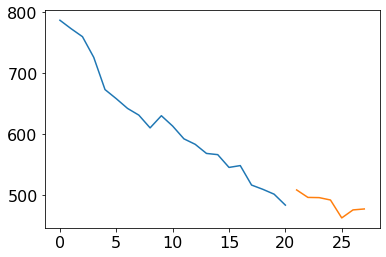

In [37]:
plt.plot(np.arange(window), d1[-window:])
plt.plot(np.arange(7)+window, y_pred[0])
plt.show()